In [27]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import time
import matplotlib.pyplot as plt
import json

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [29]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [30]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=3, dim_feedforward=128, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, d_model)
        
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_layers)
        
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = x.unsqueeze(1)  # Adding sequence length dimension
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Pooling over sequence dimension
        x = self.fc(x)
        return x.squeeze(-1)

In [31]:
def create_sequences(data, seq_length):

    #normalizaing the dataset also adding volume and close values
    columns_to_normalize = ["close","volume"]  
    scaler = MinMaxScaler()
    data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
    data["feature"] = data["close"] + data["volume"]
    
    columns_to_select = ["timestamp", "feature","Encoded_value"]
    data = data[columns_to_select]
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data = data.sort_values(by="timestamp").reset_index(drop=True)
    
    sequence_length = seq_length
    sequences, targets = [], []

    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length]["feature"].values  # Only "feature" values for sequence
        encoded_value = data.iloc[i + sequence_length - 1]["Encoded_value"]  # Encoded value from last step
        target = data.iloc[i + sequence_length]["feature"]  # Only "feature" in target
    
        # Append encoded_value as the last entry in seq
        seq = np.append(seq, encoded_value)
    
        sequences.append(seq)
        targets.append(target)
    
    sequences = np.array(sequences)  # Convert to NumPy array
    targets = np.array(targets)
    return sequences, targets

In [32]:
def data_preprocessing(df,seq_length):
    columns_to_select = ["timestamp", "close", "volume","Encoded_value"]
    df = df[columns_to_select]
    # Create sequences + normalization
    X, y = create_sequences(df, seq_length)
    # train val test split
    train_size = int(0.8 * len(X))  # 80% for training
    val_size = int(0.1 * len(X))    # 10% for validation
    test_size = len(X) - train_size - val_size  # Remaining 10% for testing
    
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
    
    # Print dataset shapes
    print(f"X_train shape: {X_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"y_test shape: {y_test.shape}")

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).contiguous()
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).contiguous()
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).contiguous()
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).contiguous()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).contiguous()
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).contiguous()
    
    
    train_dataset = StockDataset(X_train_tensor, y_train_tensor)
    val_dataset = StockDataset(X_val_tensor, y_val_tensor)
    test_dataset = StockDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              num_workers=4, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                            num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    
    print(f"Train Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}, Test Samples: {len(test_dataset)}")
    
    return train_loader,val_loader,test_loader

In [33]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, Time: {epoch_time:.2f} sec")
    
    return train_losses, val_losses


In [34]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
    
    return total_loss / len(test_loader)

In [35]:
data_dir = "/kaggle/input/new-historical-dataset/dataset/historical_data"
stocks_symbols = pd.read_csv('/kaggle/input/new-historical-dataset/dataset/ind_nifty50list.csv')
stocks_symbols = stocks_symbols.drop(columns=['Company Name','Industry','Series','ISIN Code'])
print(stocks_symbols.head())

       Symbol
0    ADANIENT
1  ADANIPORTS
2  APOLLOHOSP
3  ASIANPAINT
4    AXISBANK


In [36]:
# Initialize LabelEncoder
le = LabelEncoder()
stocks_symbols['Symbol_Encoded'] = le.fit_transform(stocks_symbols['Symbol'])

# Create a mapping dictionary
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
mapping_df = pd.DataFrame(list(label_mapping.items()), columns=["Symbol", "Encoded_Value"])
mapping_df.to_csv("label_mapping.csv", index=False)
print(mapping_df.head())

       Symbol  Encoded_Value
0    ADANIENT              0
1  ADANIPORTS              1
2  APOLLOHOSP              2
3  ASIANPAINT              3
4    AXISBANK              4


In [37]:
input_dim = 31  # Number of features
embed_dim = 64
num_heads = 4
ff_dim = 128
num_layers = 3
dropout = 0.1
lr = 0.001
num_epochs = 50
batch_size = 512
seq_length = 30

In [38]:
model = TimeSeriesTransformer(input_dim, d_model=embed_dim, nhead=num_heads, num_layers=num_layers, dim_feedforward=ff_dim, dropout=dropout)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TimeSeriesTransformer(
  (input_layer): Linear(in_features=31, out_features=64, bias=True)
  (transformer_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=128, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_f

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.415864, Val Loss: 0.006767, Time: 0.69 sec
Epoch 2/50, Train Loss: 0.149125, Val Loss: 0.198927, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.126667, Val Loss: 0.006895, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.119699, Val Loss: 0.017252, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.095971, Val Loss: 0.030055, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.089733, Val Loss: 0.076635, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.092701, Val Loss: 0.019991, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.077162, Val Loss: 0.005501, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.085139, Val Loss: 0.005836, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.073910, Val Loss: 0.025016, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.079334, Val Loss: 0.034685, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.076590, Val Loss: 0.013447, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.074683, Val Loss: 0.006599, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.074691, Val Loss: 0.010387, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.07

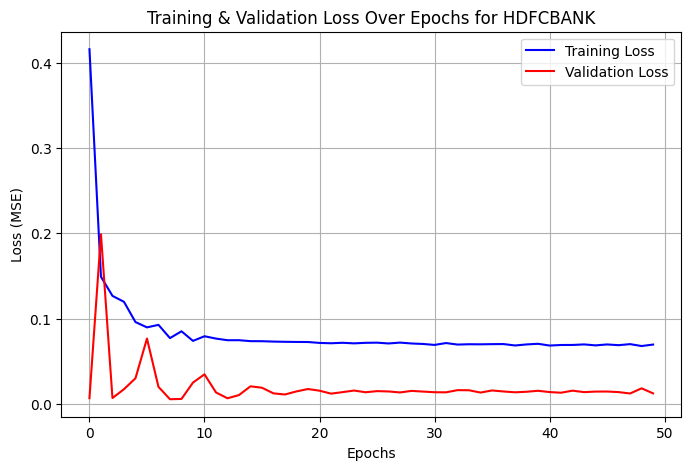

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.078226, Val Loss: 0.117666, Time: 0.21 sec
Epoch 2/50, Train Loss: 0.074129, Val Loss: 0.097066, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.065183, Val Loss: 0.026522, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.067357, Val Loss: 0.059342, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.066970, Val Loss: 0.093469, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.064478, Val Loss: 0.047787, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.064001, Val Loss: 0.049409, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.062601, Val Loss: 0.075914, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.063401, Val Loss: 0.071201, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.062312, Val Loss: 0.053979, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.062562, Val Loss: 0.059490, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.063273, Val Loss: 0.069235, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.061681, Val Loss: 0.067362, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.062127, Val Loss: 0.054169, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.06

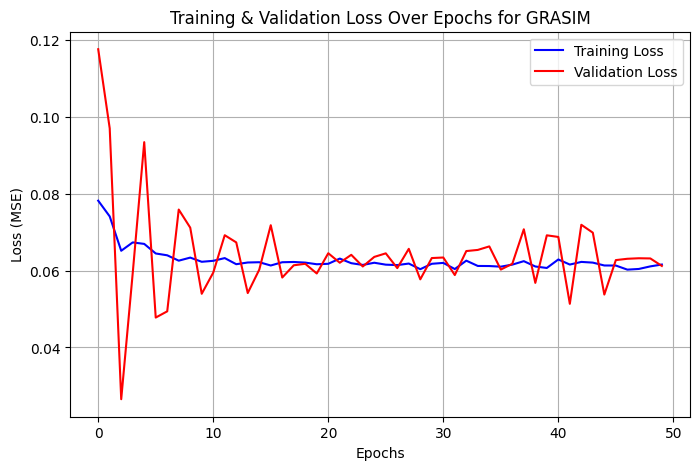

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.069347, Val Loss: 0.199421, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.070385, Val Loss: 0.160635, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.066080, Val Loss: 0.087272, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.064836, Val Loss: 0.174763, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.067951, Val Loss: 0.170049, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.063980, Val Loss: 0.094378, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.066377, Val Loss: 0.146752, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.064265, Val Loss: 0.177621, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.064068, Val Loss: 0.113257, Time: 0.06 sec
Epoch 10/50, Train Loss: 0.064943, Val Loss: 0.127924, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.062923, Val Loss: 0.162967, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.064148, Val Loss: 0.143991, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.063850, Val Loss: 0.128820, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.062372, Val Loss: 0.143872, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.06

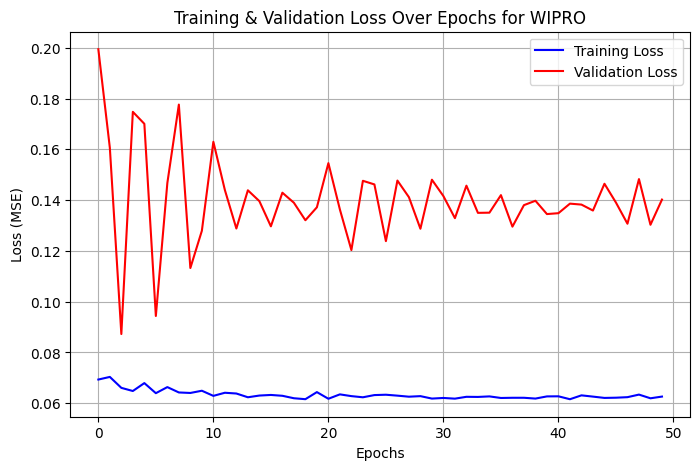

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.055576, Val Loss: 0.212829, Time: 0.21 sec
Epoch 2/50, Train Loss: 0.055620, Val Loss: 0.197446, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.051309, Val Loss: 0.108798, Time: 0.06 sec
Epoch 4/50, Train Loss: 0.053017, Val Loss: 0.181485, Time: 0.06 sec
Epoch 5/50, Train Loss: 0.052042, Val Loss: 0.181016, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.051269, Val Loss: 0.129481, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.050814, Val Loss: 0.175257, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.050767, Val Loss: 0.169796, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.049609, Val Loss: 0.137716, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.051659, Val Loss: 0.160393, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.049486, Val Loss: 0.182710, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.050915, Val Loss: 0.151955, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.049383, Val Loss: 0.154885, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.050456, Val Loss: 0.170887, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.04

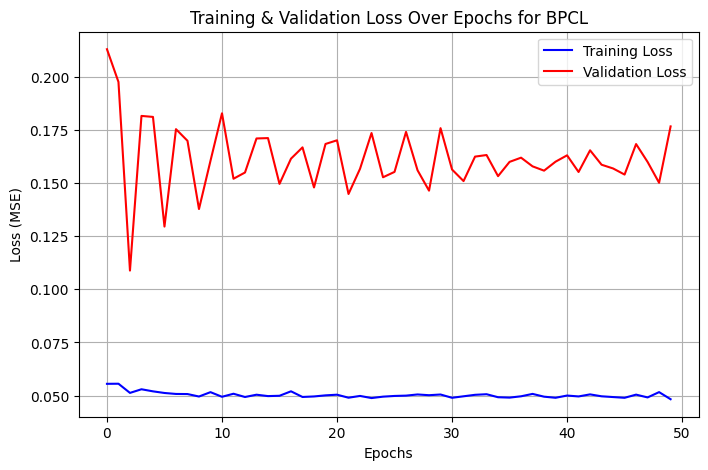

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.040763, Val Loss: 0.223386, Time: 0.22 sec
Epoch 2/50, Train Loss: 0.031979, Val Loss: 0.074287, Time: 0.05 sec
Epoch 3/50, Train Loss: 0.029660, Val Loss: 0.124259, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.026122, Val Loss: 0.157209, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.024362, Val Loss: 0.091111, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.024910, Val Loss: 0.126313, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.024468, Val Loss: 0.148849, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.022685, Val Loss: 0.103333, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.023571, Val Loss: 0.123029, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.023501, Val Loss: 0.146403, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.023701, Val Loss: 0.116847, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.023403, Val Loss: 0.122954, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.022021, Val Loss: 0.135605, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.022481, Val Loss: 0.122201, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.02

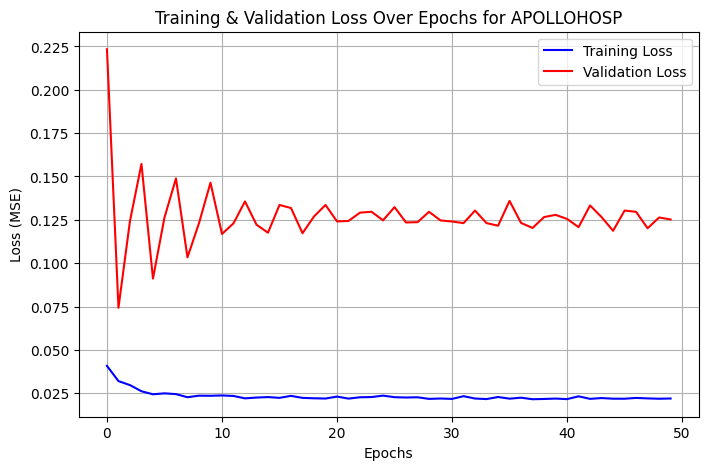

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.033535, Val Loss: 0.021927, Time: 0.22 sec
Epoch 2/50, Train Loss: 0.033117, Val Loss: 0.019849, Time: 0.05 sec
Epoch 3/50, Train Loss: 0.032610, Val Loss: 0.015996, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.032903, Val Loss: 0.019102, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.033678, Val Loss: 0.019261, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.032990, Val Loss: 0.017139, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.033116, Val Loss: 0.018088, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.032833, Val Loss: 0.018500, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.032902, Val Loss: 0.016180, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.033315, Val Loss: 0.018435, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.033035, Val Loss: 0.021462, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.032673, Val Loss: 0.016438, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.032951, Val Loss: 0.017600, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.033986, Val Loss: 0.022089, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.03

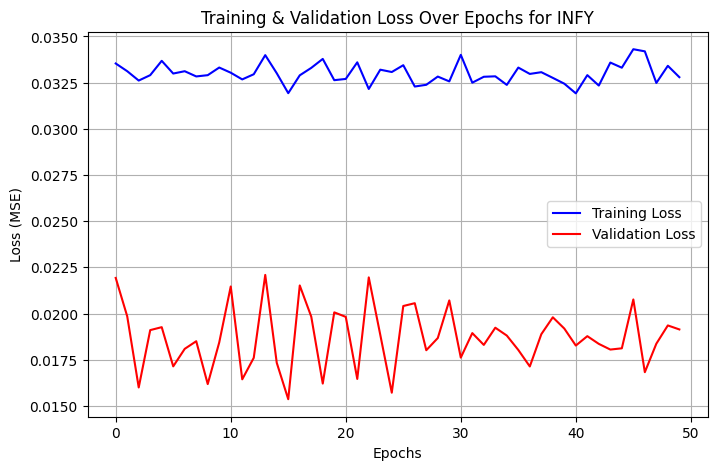

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.042414, Val Loss: 0.077082, Time: 0.21 sec
Epoch 2/50, Train Loss: 0.043362, Val Loss: 0.099876, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.037616, Val Loss: 0.164305, Time: 0.06 sec
Epoch 4/50, Train Loss: 0.036966, Val Loss: 0.096535, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.036973, Val Loss: 0.102175, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.034594, Val Loss: 0.140193, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.035522, Val Loss: 0.113544, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.034951, Val Loss: 0.104844, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.034562, Val Loss: 0.126414, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.035054, Val Loss: 0.124939, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.034983, Val Loss: 0.110899, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.033933, Val Loss: 0.118529, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.034252, Val Loss: 0.123112, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.034911, Val Loss: 0.112582, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.03

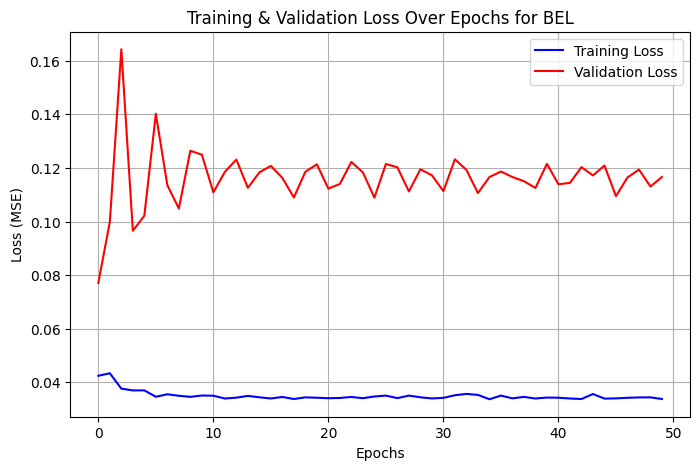

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.031070, Val Loss: 0.173602, Time: 0.22 sec
Epoch 2/50, Train Loss: 0.031953, Val Loss: 0.167269, Time: 0.05 sec
Epoch 3/50, Train Loss: 0.031509, Val Loss: 0.148820, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.031165, Val Loss: 0.168624, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.031482, Val Loss: 0.165505, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.030823, Val Loss: 0.144475, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.031533, Val Loss: 0.158913, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.032451, Val Loss: 0.169606, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.031462, Val Loss: 0.158452, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.032570, Val Loss: 0.149305, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.032039, Val Loss: 0.167508, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.031553, Val Loss: 0.164723, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.031087, Val Loss: 0.149193, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.031838, Val Loss: 0.154610, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.03

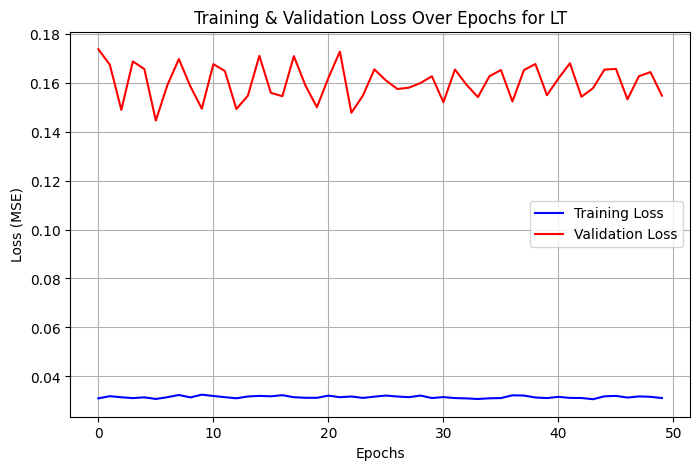

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.072501, Val Loss: 0.032000, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.072569, Val Loss: 0.047433, Time: 0.05 sec
Epoch 3/50, Train Loss: 0.067980, Val Loss: 0.106376, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.066412, Val Loss: 0.047366, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.069749, Val Loss: 0.040529, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.066617, Val Loss: 0.095404, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.066503, Val Loss: 0.064086, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.067097, Val Loss: 0.041816, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.065927, Val Loss: 0.076924, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.066269, Val Loss: 0.075299, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.066200, Val Loss: 0.047126, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.066641, Val Loss: 0.066481, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.065621, Val Loss: 0.077022, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.063966, Val Loss: 0.053171, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.06

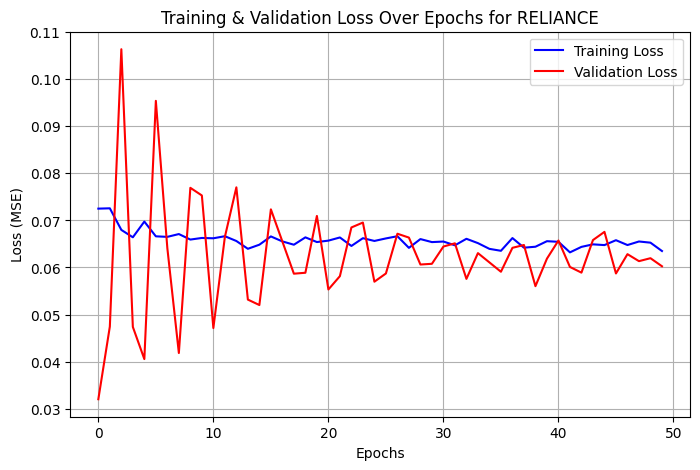

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.092076, Val Loss: 0.052962, Time: 0.22 sec
Epoch 2/50, Train Loss: 0.091745, Val Loss: 0.059625, Time: 0.05 sec
Epoch 3/50, Train Loss: 0.093732, Val Loss: 0.050453, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.091809, Val Loss: 0.052412, Time: 0.06 sec
Epoch 5/50, Train Loss: 0.091728, Val Loss: 0.056537, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.091084, Val Loss: 0.051808, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.091274, Val Loss: 0.050835, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.091410, Val Loss: 0.056996, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.091258, Val Loss: 0.056373, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.093007, Val Loss: 0.043391, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.092799, Val Loss: 0.059671, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.092633, Val Loss: 0.052054, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.091715, Val Loss: 0.052074, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.092989, Val Loss: 0.057539, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.09

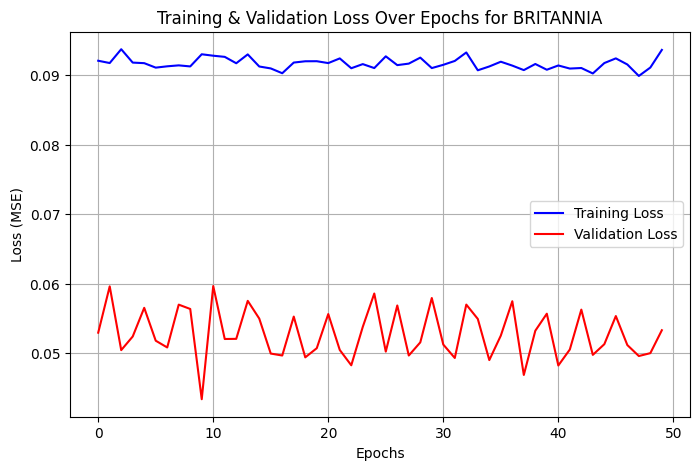

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.070914, Val Loss: 0.126965, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.072153, Val Loss: 0.106064, Time: 0.05 sec
Epoch 3/50, Train Loss: 0.069546, Val Loss: 0.065123, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.071156, Val Loss: 0.103068, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.070340, Val Loss: 0.103322, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.069050, Val Loss: 0.081987, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.068494, Val Loss: 0.088432, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.069838, Val Loss: 0.100472, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.069662, Val Loss: 0.093881, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.068762, Val Loss: 0.090427, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.068812, Val Loss: 0.101938, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.069191, Val Loss: 0.098768, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.069471, Val Loss: 0.090935, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.070399, Val Loss: 0.100835, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.06

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1570f19cf0><function _MultiProcessingDataLoaderIter.__del__ at 0x7a1570f19cf0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

Epoch 43/50, Train Loss: 0.070254, Val Loss: 0.101090, Time: 0.41 sec
Epoch 44/50, Train Loss: 0.069576, Val Loss: 0.093113, Time: 0.05 sec
Epoch 45/50, Train Loss: 0.069758, Val Loss: 0.087713, Time: 0.05 sec
Epoch 46/50, Train Loss: 0.068420, Val Loss: 0.112320, Time: 0.05 sec
Epoch 47/50, Train Loss: 0.069416, Val Loss: 0.095631, Time: 0.05 sec
Epoch 48/50, Train Loss: 0.070022, Val Loss: 0.083670, Time: 0.05 sec
Epoch 49/50, Train Loss: 0.069659, Val Loss: 0.104721, Time: 0.05 sec
Epoch 50/50, Train Loss: 0.070935, Val Loss: 0.101441, Time: 0.05 sec


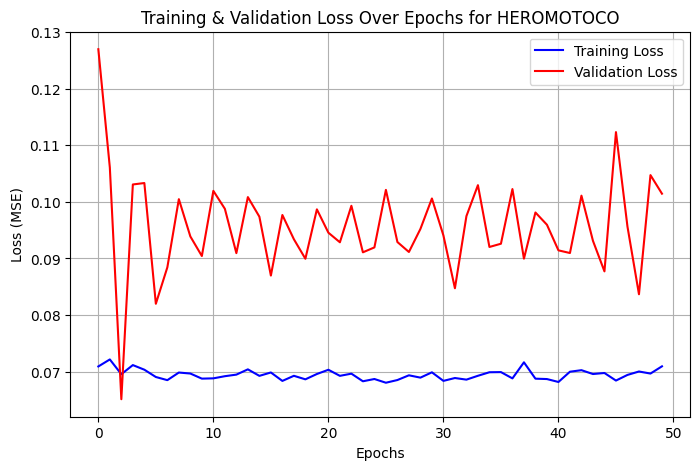

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.065055, Val Loss: 0.049165, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.065147, Val Loss: 0.044564, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.064075, Val Loss: 0.084422, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.065071, Val Loss: 0.066688, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.064408, Val Loss: 0.045683, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.063543, Val Loss: 0.071746, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.063794, Val Loss: 0.072652, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.062142, Val Loss: 0.052087, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.064053, Val Loss: 0.056583, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.064024, Val Loss: 0.075025, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.063796, Val Loss: 0.061867, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.064621, Val Loss: 0.057390, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.063777, Val Loss: 0.069184, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.064568, Val Loss: 0.065010, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.06

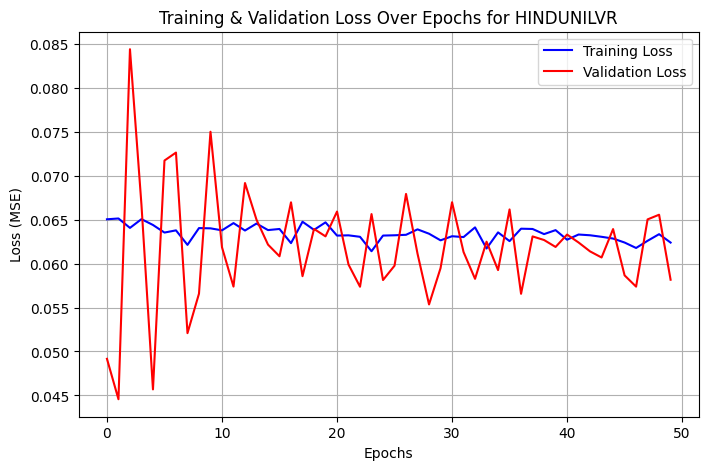

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.039981, Val Loss: 0.112818, Time: 0.22 sec
Epoch 2/50, Train Loss: 0.040762, Val Loss: 0.111412, Time: 0.05 sec
Epoch 3/50, Train Loss: 0.039565, Val Loss: 0.105553, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.040517, Val Loss: 0.106740, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.039766, Val Loss: 0.113985, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.040522, Val Loss: 0.102272, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.039767, Val Loss: 0.098535, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.040851, Val Loss: 0.117577, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.041244, Val Loss: 0.116184, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.039708, Val Loss: 0.096995, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.040121, Val Loss: 0.107361, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.039743, Val Loss: 0.116566, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.039515, Val Loss: 0.100341, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.039386, Val Loss: 0.102341, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.04

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1570f19cf0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a1570f19cf0>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

Epoch 27/50, Train Loss: 0.040194, Val Loss: 0.107002, Time: 0.39 sec
Epoch 28/50, Train Loss: 0.039767, Val Loss: 0.103942, Time: 0.05 sec
Epoch 29/50, Train Loss: 0.040336, Val Loss: 0.110618, Time: 0.05 sec
Epoch 30/50, Train Loss: 0.040106, Val Loss: 0.111695, Time: 0.05 sec
Epoch 31/50, Train Loss: 0.039545, Val Loss: 0.102056, Time: 0.05 sec
Epoch 32/50, Train Loss: 0.040215, Val Loss: 0.107282, Time: 0.06 sec
Epoch 33/50, Train Loss: 0.039621, Val Loss: 0.108650, Time: 0.06 sec
Epoch 34/50, Train Loss: 0.040757, Val Loss: 0.104807, Time: 0.06 sec
Epoch 35/50, Train Loss: 0.039810, Val Loss: 0.108239, Time: 0.05 sec
Epoch 36/50, Train Loss: 0.040052, Val Loss: 0.104727, Time: 0.05 sec
Epoch 37/50, Train Loss: 0.039699, Val Loss: 0.113180, Time: 0.05 sec
Epoch 38/50, Train Loss: 0.040959, Val Loss: 0.106212, Time: 0.05 sec
Epoch 39/50, Train Loss: 0.040169, Val Loss: 0.105370, Time: 0.05 sec
Epoch 40/50, Train Loss: 0.039968, Val Loss: 0.114301, Time: 0.06 sec
Epoch 41/50, Train L

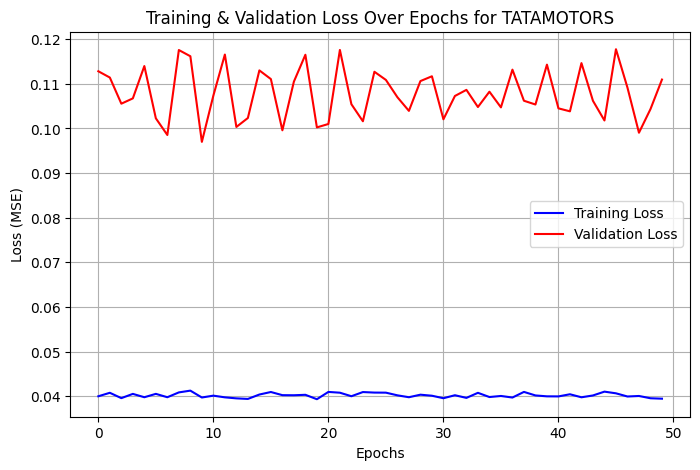

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1570f19cf0><function _MultiProcessingDataLoaderIter.__del__ at 0x7a1570f19cf0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.

Epoch 1/50, Train Loss: 0.067966, Val Loss: 0.094201, Time: 0.57 sec


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1570f19cf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Epoch 2/50, Train Loss: 0.067679, Val Loss: 0.089834, Time: 0.35 sec
Epoch 3/50, Train Loss: 0.068107, Val Loss: 0.087465, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.067028, Val Loss: 0.090591, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.067719, Val Loss: 0.088653, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.068160, Val Loss: 0.090549, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.067968, Val Loss: 0.093786, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.067234, Val Loss: 0.087306, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.068213, Val Loss: 0.089825, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.066433, Val Loss: 0.093783, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.067807, Val Loss: 0.089984, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.068165, Val Loss: 0.082535, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.068185, Val Loss: 0.095050, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.067996, Val Loss: 0.095272, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.068364, Val Loss: 0.080859, Time: 0.05 sec
Epoch 16/50, Train Loss: 0.0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1570f19cf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Epoch 39/50, Train Loss: 0.067000, Val Loss: 0.086917, Time: 0.37 sec
Epoch 40/50, Train Loss: 0.067480, Val Loss: 0.088981, Time: 0.05 sec
Epoch 41/50, Train Loss: 0.067080, Val Loss: 0.091671, Time: 0.05 sec
Epoch 42/50, Train Loss: 0.068399, Val Loss: 0.089980, Time: 0.05 sec
Epoch 43/50, Train Loss: 0.067335, Val Loss: 0.092129, Time: 0.05 sec
Epoch 44/50, Train Loss: 0.066778, Val Loss: 0.093279, Time: 0.05 sec
Epoch 45/50, Train Loss: 0.067404, Val Loss: 0.087470, Time: 0.05 sec
Epoch 46/50, Train Loss: 0.066107, Val Loss: 0.089868, Time: 0.05 sec
Epoch 47/50, Train Loss: 0.067485, Val Loss: 0.094858, Time: 0.05 sec
Epoch 48/50, Train Loss: 0.067363, Val Loss: 0.088928, Time: 0.05 sec
Epoch 49/50, Train Loss: 0.068522, Val Loss: 0.093131, Time: 0.05 sec
Epoch 50/50, Train Loss: 0.067570, Val Loss: 0.099123, Time: 0.05 sec


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a1570f19cf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  F

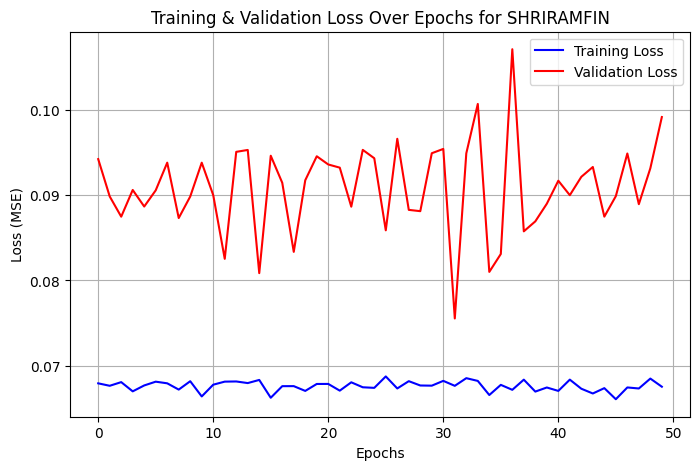

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.053178, Val Loss: 0.011714, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.054829, Val Loss: 0.007320, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.048356, Val Loss: 0.014840, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.049582, Val Loss: 0.006671, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.047804, Val Loss: 0.008504, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.047126, Val Loss: 0.008235, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.047563, Val Loss: 0.006988, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.046220, Val Loss: 0.007144, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.046416, Val Loss: 0.006685, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.045541, Val Loss: 0.007106, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.046005, Val Loss: 0.006462, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.046646, Val Loss: 0.006440, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.046309, Val Loss: 0.007155, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.046776, Val Loss: 0.006474, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.04

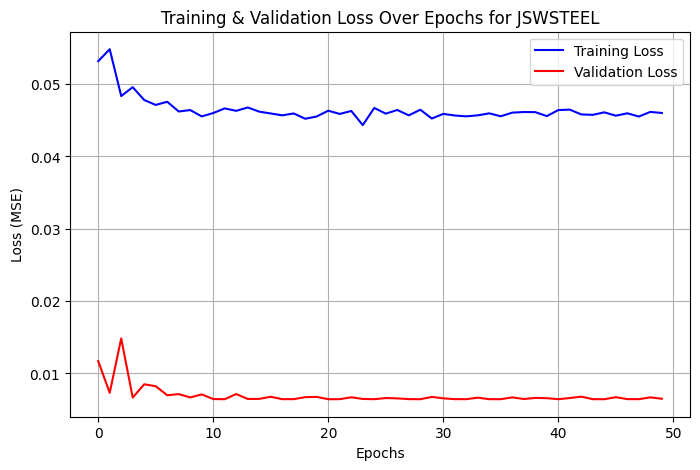

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.090540, Val Loss: 0.068505, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.091678, Val Loss: 0.072868, Time: 0.05 sec
Epoch 3/50, Train Loss: 0.091073, Val Loss: 0.063234, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.089757, Val Loss: 0.068742, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.091494, Val Loss: 0.073213, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.092560, Val Loss: 0.073521, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.090828, Val Loss: 0.073401, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.089624, Val Loss: 0.068884, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.091331, Val Loss: 0.067717, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.092573, Val Loss: 0.076623, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.093372, Val Loss: 0.074732, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.091503, Val Loss: 0.068515, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.089396, Val Loss: 0.068527, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.089423, Val Loss: 0.066253, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.09

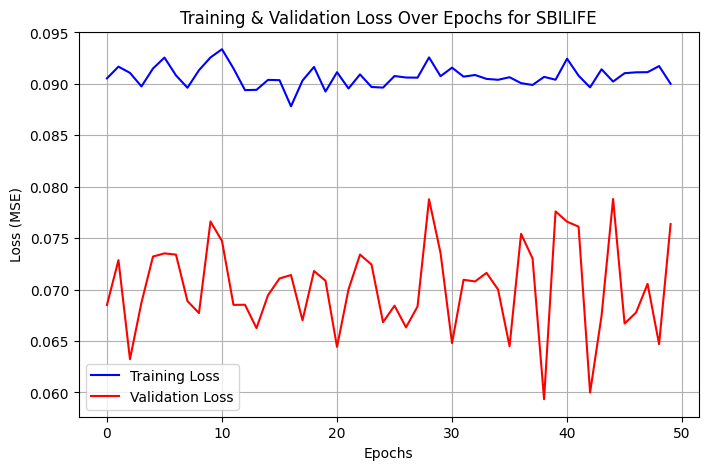

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.054633, Val Loss: 0.050832, Time: 0.22 sec
Epoch 2/50, Train Loss: 0.054767, Val Loss: 0.054747, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.051025, Val Loss: 0.035980, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.054826, Val Loss: 0.038548, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.052140, Val Loss: 0.053482, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.053024, Val Loss: 0.042180, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.051307, Val Loss: 0.037677, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.051616, Val Loss: 0.045629, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.052315, Val Loss: 0.047545, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.052516, Val Loss: 0.039882, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.052393, Val Loss: 0.041022, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.051632, Val Loss: 0.045648, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.051879, Val Loss: 0.043822, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.051455, Val Loss: 0.041902, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.05

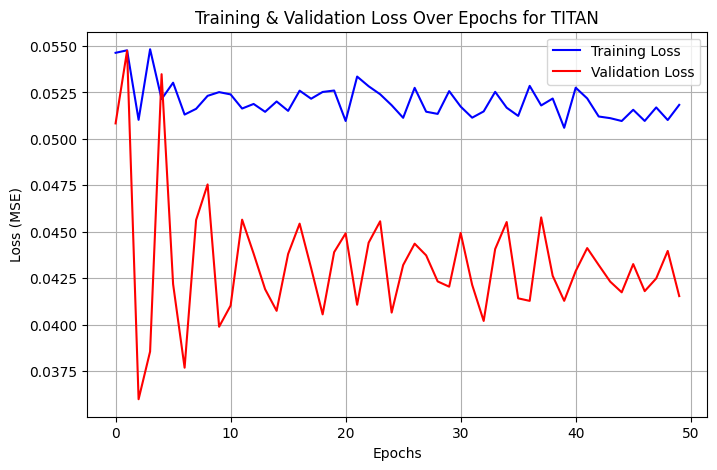

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.069607, Val Loss: 0.099280, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.069221, Val Loss: 0.102356, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.068069, Val Loss: 0.097020, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.069606, Val Loss: 0.099493, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.070393, Val Loss: 0.105290, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.069178, Val Loss: 0.101103, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.070357, Val Loss: 0.099770, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.068173, Val Loss: 0.106246, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.068600, Val Loss: 0.101657, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.068903, Val Loss: 0.096549, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.069982, Val Loss: 0.109642, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.069154, Val Loss: 0.097601, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.069920, Val Loss: 0.090541, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.069148, Val Loss: 0.112247, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.06

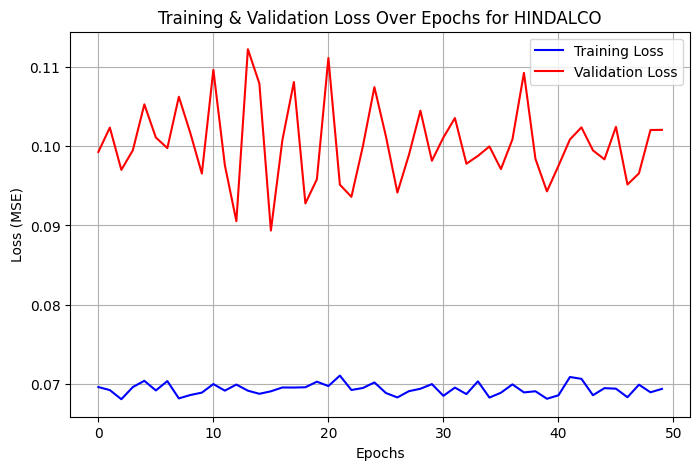

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.056164, Val Loss: 0.183779, Time: 0.22 sec
Epoch 2/50, Train Loss: 0.056702, Val Loss: 0.181425, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.053757, Val Loss: 0.121154, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.054529, Val Loss: 0.143614, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.053700, Val Loss: 0.184366, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.054182, Val Loss: 0.145877, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.052682, Val Loss: 0.144566, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.052766, Val Loss: 0.169764, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.053254, Val Loss: 0.158488, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.052686, Val Loss: 0.142065, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.052436, Val Loss: 0.162831, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.052278, Val Loss: 0.158052, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.054255, Val Loss: 0.147947, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.051480, Val Loss: 0.151260, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.05

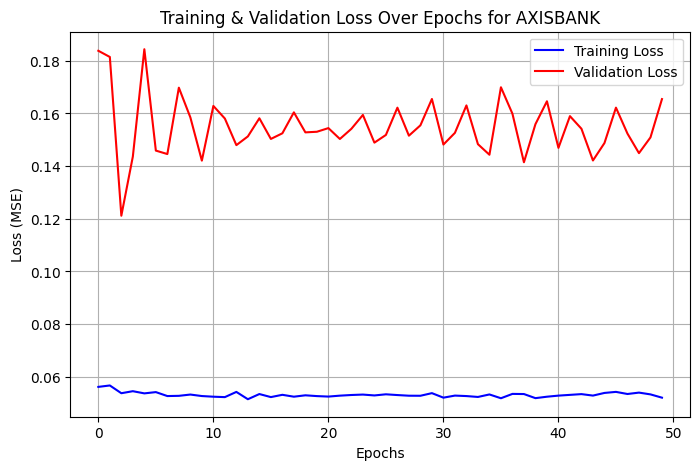

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.026404, Val Loss: 0.105866, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.025793, Val Loss: 0.113340, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.024489, Val Loss: 0.069278, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.025381, Val Loss: 0.082955, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.024600, Val Loss: 0.114510, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.025470, Val Loss: 0.090180, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.024895, Val Loss: 0.075510, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.025028, Val Loss: 0.101391, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.024163, Val Loss: 0.101914, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.023723, Val Loss: 0.084757, Time: 0.06 sec
Epoch 11/50, Train Loss: 0.024368, Val Loss: 0.088759, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.024015, Val Loss: 0.097617, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.024389, Val Loss: 0.090803, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.024528, Val Loss: 0.090433, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.02

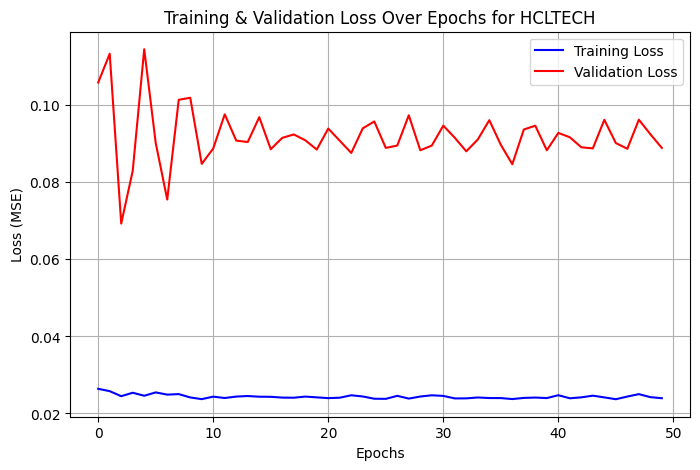

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.129640, Val Loss: 0.011033, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.116275, Val Loss: 0.023752, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.102314, Val Loss: 0.008188, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.105536, Val Loss: 0.007251, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.096409, Val Loss: 0.007872, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.098557, Val Loss: 0.003127, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.095998, Val Loss: 0.005172, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.096603, Val Loss: 0.001781, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.092692, Val Loss: 0.004935, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.096017, Val Loss: 0.002194, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.093440, Val Loss: 0.002700, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.094561, Val Loss: 0.001773, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.093539, Val Loss: 0.002598, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.093784, Val Loss: 0.002163, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.09

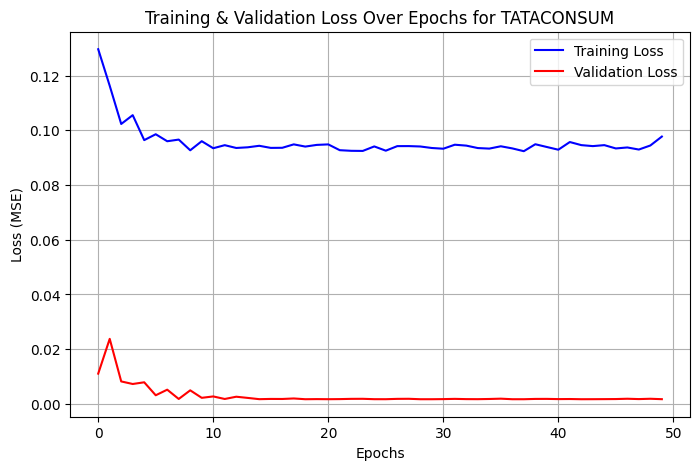

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.080620, Val Loss: 0.156131, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.073747, Val Loss: 0.240147, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.078879, Val Loss: 0.177480, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.071205, Val Loss: 0.106639, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.075600, Val Loss: 0.112025, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.072444, Val Loss: 0.169288, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.072007, Val Loss: 0.190299, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.071614, Val Loss: 0.154045, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.070943, Val Loss: 0.126437, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.072057, Val Loss: 0.133567, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.070811, Val Loss: 0.157711, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.070950, Val Loss: 0.164989, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.070611, Val Loss: 0.154759, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.070918, Val Loss: 0.142757, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.07

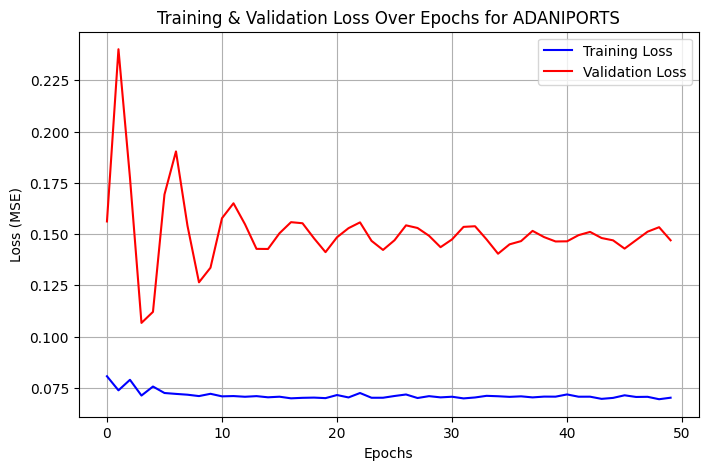

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.086283, Val Loss: 0.044890, Time: 0.30 sec
Epoch 2/50, Train Loss: 0.074539, Val Loss: 0.094775, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.080257, Val Loss: 0.082825, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.077228, Val Loss: 0.043688, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.075995, Val Loss: 0.030431, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.077508, Val Loss: 0.045014, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.073978, Val Loss: 0.066426, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.073936, Val Loss: 0.068966, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.073398, Val Loss: 0.051526, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.073551, Val Loss: 0.044243, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.073678, Val Loss: 0.046869, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.072125, Val Loss: 0.055965, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.071606, Val Loss: 0.059902, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.074308, Val Loss: 0.056415, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.07

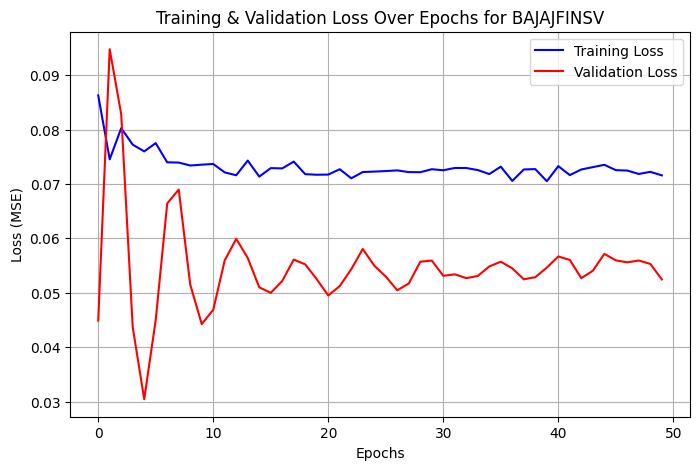

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.039259, Val Loss: 0.279397, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.030630, Val Loss: 0.387752, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.034959, Val Loss: 0.394229, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.033265, Val Loss: 0.315757, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.030513, Val Loss: 0.262545, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.032368, Val Loss: 0.280111, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.030896, Val Loss: 0.335690, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.032340, Val Loss: 0.360703, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.032784, Val Loss: 0.332782, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.030180, Val Loss: 0.297951, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.030382, Val Loss: 0.293374, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.030417, Val Loss: 0.317555, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.030325, Val Loss: 0.335926, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.030783, Val Loss: 0.330679, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.03

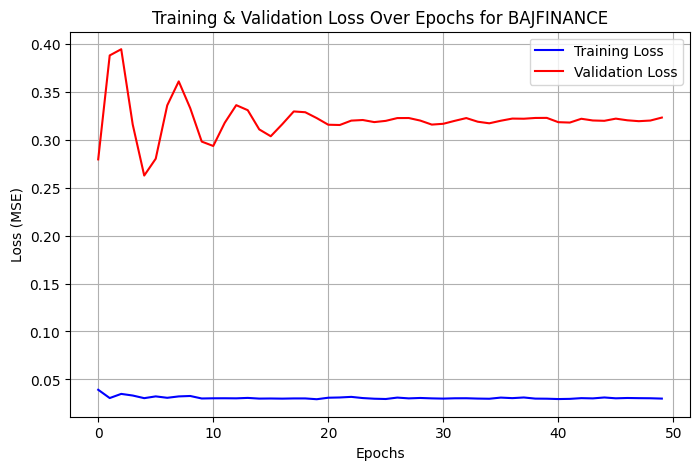

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.088023, Val Loss: 0.008014, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.058572, Val Loss: 0.060028, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.069360, Val Loss: 0.065001, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.063352, Val Loss: 0.026065, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.056071, Val Loss: 0.009052, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.061119, Val Loss: 0.009574, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.057578, Val Loss: 0.021565, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.055321, Val Loss: 0.036149, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.057665, Val Loss: 0.034778, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.055959, Val Loss: 0.023071, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.056644, Val Loss: 0.015620, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.055987, Val Loss: 0.017025, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.057874, Val Loss: 0.022127, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.054927, Val Loss: 0.028813, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.05

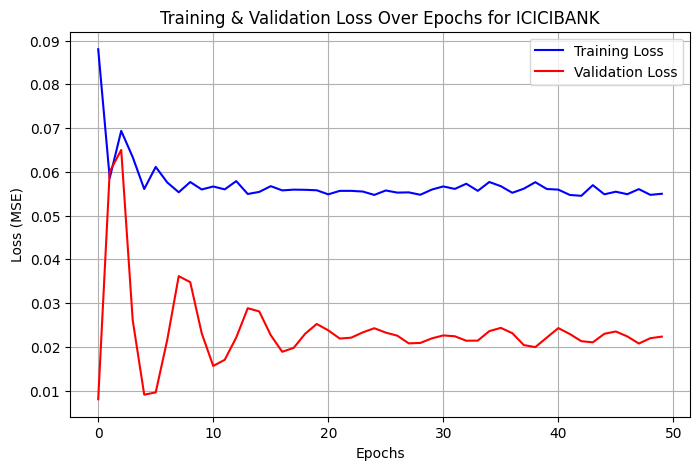

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.075203, Val Loss: 0.080265, Time: 0.28 sec
Epoch 2/50, Train Loss: 0.074399, Val Loss: 0.075669, Time: 0.07 sec
Epoch 3/50, Train Loss: 0.076299, Val Loss: 0.072746, Time: 0.06 sec
Epoch 4/50, Train Loss: 0.075323, Val Loss: 0.076281, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.075304, Val Loss: 0.080259, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.075243, Val Loss: 0.081691, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.075047, Val Loss: 0.079674, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.075357, Val Loss: 0.077913, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.075008, Val Loss: 0.075299, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.074613, Val Loss: 0.075454, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.075072, Val Loss: 0.076784, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.075683, Val Loss: 0.078531, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.075388, Val Loss: 0.079070, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.074199, Val Loss: 0.078142, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.07

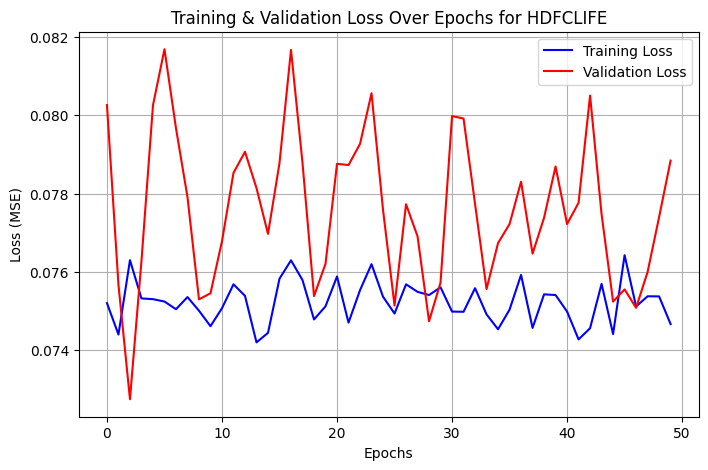

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.101343, Val Loss: 0.130323, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.096024, Val Loss: 0.085587, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.099597, Val Loss: 0.076687, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.097254, Val Loss: 0.100534, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.096233, Val Loss: 0.125811, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.097604, Val Loss: 0.129476, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.097393, Val Loss: 0.112693, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.095140, Val Loss: 0.099964, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.095111, Val Loss: 0.096083, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.097449, Val Loss: 0.102921, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.096191, Val Loss: 0.113595, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.095910, Val Loss: 0.118256, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.096209, Val Loss: 0.112620, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.094782, Val Loss: 0.105446, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.09

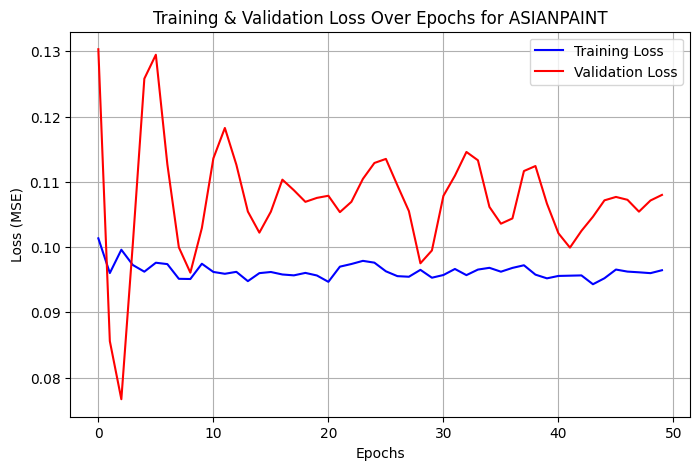

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.082138, Val Loss: 0.062367, Time: 0.25 sec
Epoch 2/50, Train Loss: 0.073808, Val Loss: 0.112320, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.077207, Val Loss: 0.124067, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.077194, Val Loss: 0.095950, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.073847, Val Loss: 0.067917, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.074994, Val Loss: 0.061066, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.075093, Val Loss: 0.074735, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.073288, Val Loss: 0.096793, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.073564, Val Loss: 0.104445, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.073291, Val Loss: 0.088856, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.074840, Val Loss: 0.074204, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.072596, Val Loss: 0.071253, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.073872, Val Loss: 0.080727, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.073800, Val Loss: 0.089532, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.07

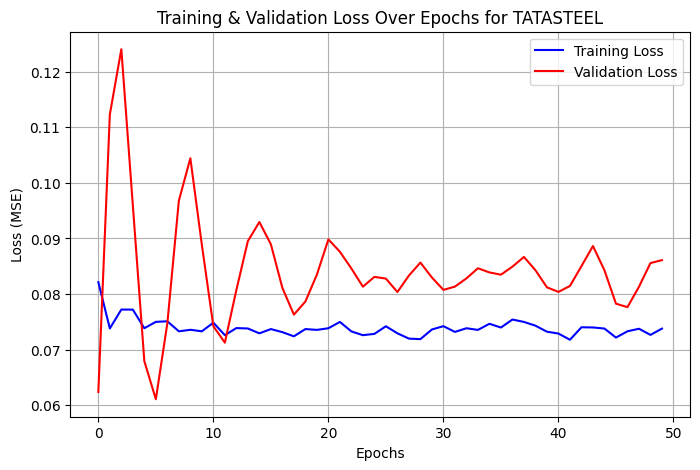

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.080608, Val Loss: 0.185125, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.080225, Val Loss: 0.150703, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.080820, Val Loss: 0.142097, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.080693, Val Loss: 0.158034, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.078703, Val Loss: 0.172737, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.080108, Val Loss: 0.177416, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.079869, Val Loss: 0.172402, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.079922, Val Loss: 0.167881, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.078822, Val Loss: 0.165397, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.078928, Val Loss: 0.161529, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.080285, Val Loss: 0.161532, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.080365, Val Loss: 0.169275, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.079474, Val Loss: 0.173154, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.080677, Val Loss: 0.172347, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.07

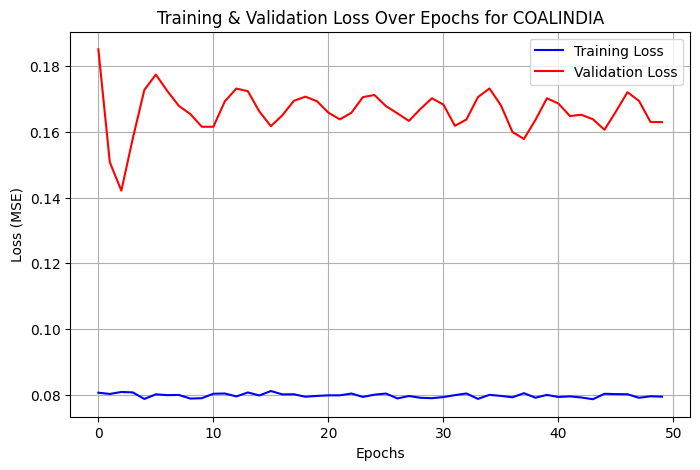

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.095645, Val Loss: 0.059697, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.086480, Val Loss: 0.023095, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.089065, Val Loss: 0.017084, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.088556, Val Loss: 0.028704, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.086681, Val Loss: 0.049530, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.086202, Val Loss: 0.060068, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.086440, Val Loss: 0.049304, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.085924, Val Loss: 0.034096, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.084193, Val Loss: 0.029947, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.085444, Val Loss: 0.033522, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.085076, Val Loss: 0.041807, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.083814, Val Loss: 0.046757, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.085025, Val Loss: 0.043765, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.085075, Val Loss: 0.038211, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.08

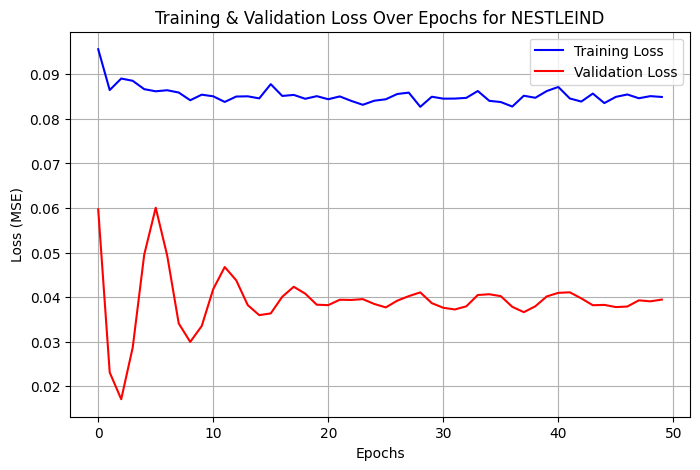

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.112493, Val Loss: 0.030151, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.050497, Val Loss: 0.147706, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.059764, Val Loss: 0.219301, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.064921, Val Loss: 0.146306, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.044880, Val Loss: 0.067467, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.047535, Val Loss: 0.049884, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.048337, Val Loss: 0.074512, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.042535, Val Loss: 0.112250, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.043336, Val Loss: 0.122311, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.042677, Val Loss: 0.103575, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.043116, Val Loss: 0.083405, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.041671, Val Loss: 0.078956, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.041754, Val Loss: 0.086173, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.041646, Val Loss: 0.099830, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.04

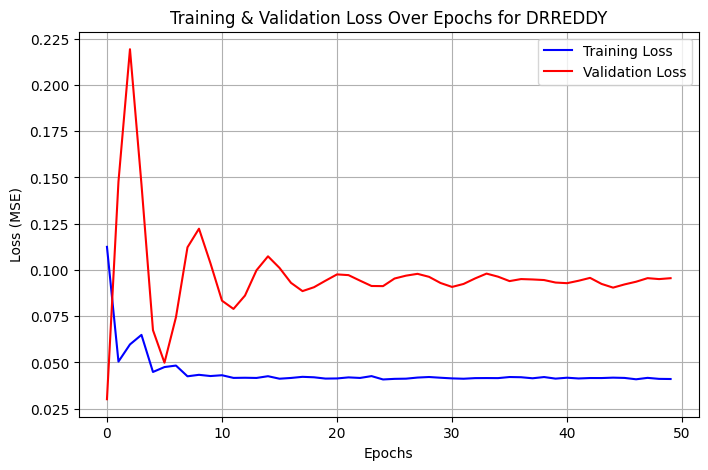

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.062020, Val Loss: 0.132790, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.061479, Val Loss: 0.121823, Time: 0.05 sec
Epoch 3/50, Train Loss: 0.062218, Val Loss: 0.115907, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.060388, Val Loss: 0.118770, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.062890, Val Loss: 0.125110, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.061129, Val Loss: 0.130485, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.062499, Val Loss: 0.128789, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.060857, Val Loss: 0.126101, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.061364, Val Loss: 0.120480, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.061939, Val Loss: 0.118702, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.060510, Val Loss: 0.122723, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.062376, Val Loss: 0.126585, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.061750, Val Loss: 0.125620, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.062128, Val Loss: 0.126045, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.06

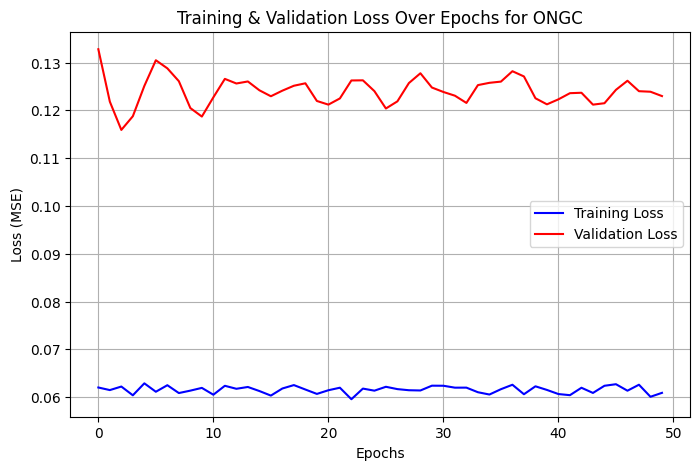

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.084236, Val Loss: 0.104914, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.037877, Val Loss: 0.166697, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.041040, Val Loss: 0.208630, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.044898, Val Loss: 0.168811, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.033327, Val Loss: 0.132709, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.032099, Val Loss: 0.120980, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.033602, Val Loss: 0.127550, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.031927, Val Loss: 0.143045, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.030928, Val Loss: 0.151867, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.031997, Val Loss: 0.148728, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.030117, Val Loss: 0.138178, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.030312, Val Loss: 0.132222, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.030909, Val Loss: 0.133165, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.031249, Val Loss: 0.138263, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.03

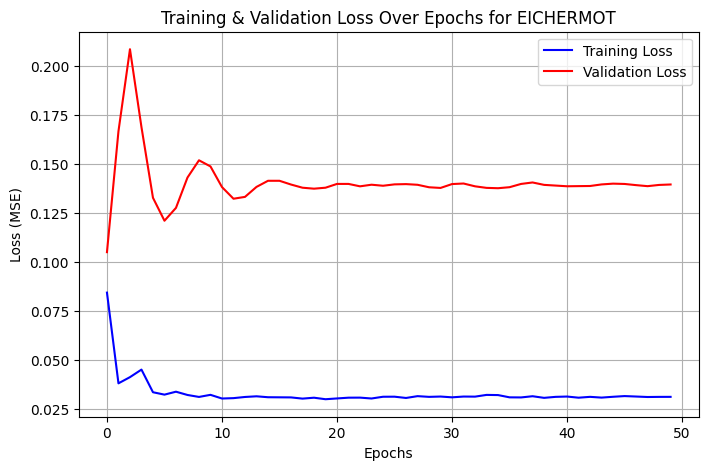

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.108413, Val Loss: 0.013509, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.034515, Val Loss: 0.143522, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.042914, Val Loss: 0.154505, Time: 0.37 sec
Epoch 4/50, Train Loss: 0.029526, Val Loss: 0.056256, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.027717, Val Loss: 0.037893, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.025916, Val Loss: 0.070345, Time: 0.32 sec
Epoch 7/50, Train Loss: 0.023457, Val Loss: 0.104062, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.024558, Val Loss: 0.100261, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.023000, Val Loss: 0.077352, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.022668, Val Loss: 0.062006, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.022736, Val Loss: 0.063687, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.022993, Val Loss: 0.075279, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.022317, Val Loss: 0.085362, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.023594, Val Loss: 0.085611, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.02

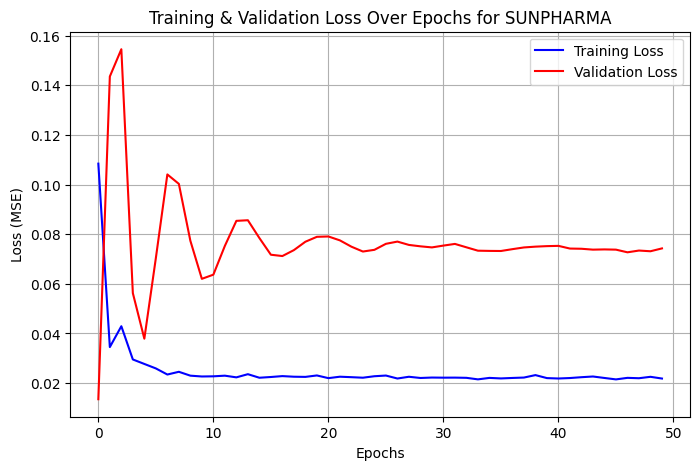

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.044646, Val Loss: 0.006669, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.041398, Val Loss: 0.007517, Time: 0.05 sec
Epoch 3/50, Train Loss: 0.041821, Val Loss: 0.009819, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.043058, Val Loss: 0.008914, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.042014, Val Loss: 0.006942, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.041390, Val Loss: 0.006517, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.041352, Val Loss: 0.006532, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.041832, Val Loss: 0.006605, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.042158, Val Loss: 0.007313, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.041361, Val Loss: 0.007853, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.042142, Val Loss: 0.007364, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.041368, Val Loss: 0.006898, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.041558, Val Loss: 0.006762, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.042651, Val Loss: 0.006816, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.04

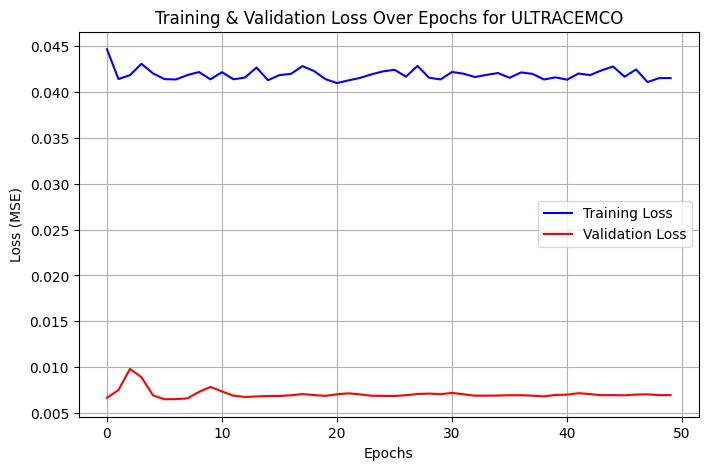

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.079946, Val Loss: 0.098195, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.059812, Val Loss: 0.037853, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.060104, Val Loss: 0.018850, Time: 0.06 sec
Epoch 4/50, Train Loss: 0.064767, Val Loss: 0.027045, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.059198, Val Loss: 0.051145, Time: 0.06 sec
Epoch 6/50, Train Loss: 0.057862, Val Loss: 0.071680, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.058625, Val Loss: 0.074515, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.059142, Val Loss: 0.063252, Time: 0.06 sec
Epoch 9/50, Train Loss: 0.058437, Val Loss: 0.050107, Time: 0.06 sec
Epoch 10/50, Train Loss: 0.057191, Val Loss: 0.043087, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.057464, Val Loss: 0.042709, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.056808, Val Loss: 0.046235, Time: 0.06 sec
Epoch 13/50, Train Loss: 0.057367, Val Loss: 0.050229, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.056073, Val Loss: 0.054984, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.05

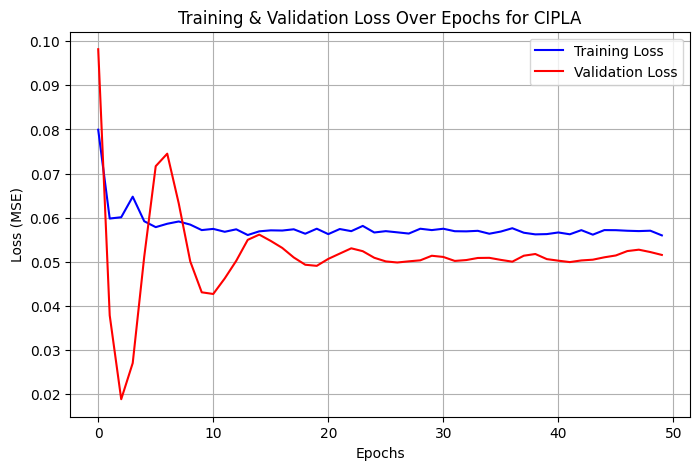

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.081801, Val Loss: 0.008915, Time: 0.25 sec
Epoch 2/50, Train Loss: 0.041531, Val Loss: 0.045180, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.024671, Val Loss: 0.108609, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.035014, Val Loss: 0.118813, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.031739, Val Loss: 0.069547, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.024876, Val Loss: 0.032109, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.026954, Val Loss: 0.044829, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.024219, Val Loss: 0.068359, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.024519, Val Loss: 0.074795, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.024288, Val Loss: 0.065906, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.024091, Val Loss: 0.053863, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.024003, Val Loss: 0.048832, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.024091, Val Loss: 0.051499, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.024054, Val Loss: 0.058420, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.02

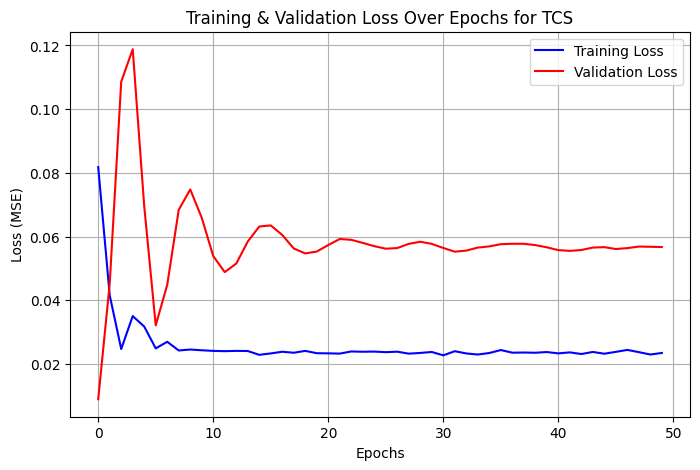

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.116684, Val Loss: 0.347057, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.091106, Val Loss: 0.201316, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.085350, Val Loss: 0.133258, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.088513, Val Loss: 0.153484, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.083136, Val Loss: 0.203382, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.081323, Val Loss: 0.241190, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.081109, Val Loss: 0.251114, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.081294, Val Loss: 0.236596, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.081480, Val Loss: 0.216147, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.080961, Val Loss: 0.201379, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.079600, Val Loss: 0.196774, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.081100, Val Loss: 0.199908, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.080586, Val Loss: 0.209436, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.080524, Val Loss: 0.216889, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.08

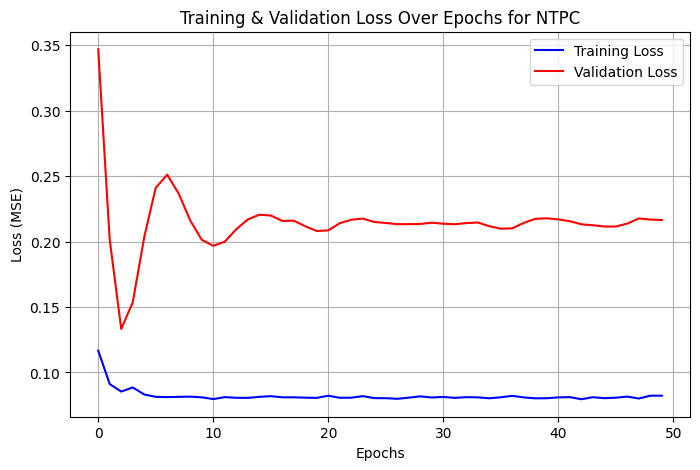

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.083853, Val Loss: 0.087079, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.073163, Val Loss: 0.130548, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.070167, Val Loss: 0.176600, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.071032, Val Loss: 0.197001, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.073601, Val Loss: 0.187729, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.072711, Val Loss: 0.161868, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.069553, Val Loss: 0.136786, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.069898, Val Loss: 0.125441, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.070630, Val Loss: 0.126054, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.071184, Val Loss: 0.133765, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.069087, Val Loss: 0.144438, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.069758, Val Loss: 0.151787, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.070239, Val Loss: 0.154485, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.069732, Val Loss: 0.152932, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.06

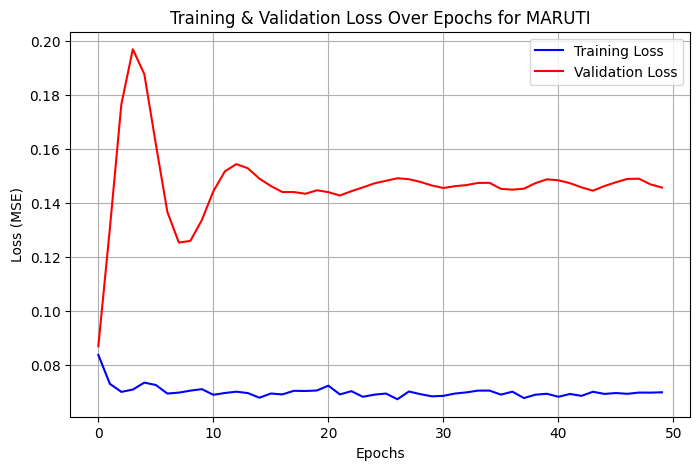

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.045938, Val Loss: 0.175662, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.046566, Val Loss: 0.182454, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.045147, Val Loss: 0.186035, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.045697, Val Loss: 0.188455, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.046816, Val Loss: 0.188739, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.044775, Val Loss: 0.187138, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.045982, Val Loss: 0.185061, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.045717, Val Loss: 0.182204, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.044989, Val Loss: 0.181989, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.045504, Val Loss: 0.182720, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.047356, Val Loss: 0.184077, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.045209, Val Loss: 0.183746, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.047246, Val Loss: 0.185053, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.045983, Val Loss: 0.185287, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.04

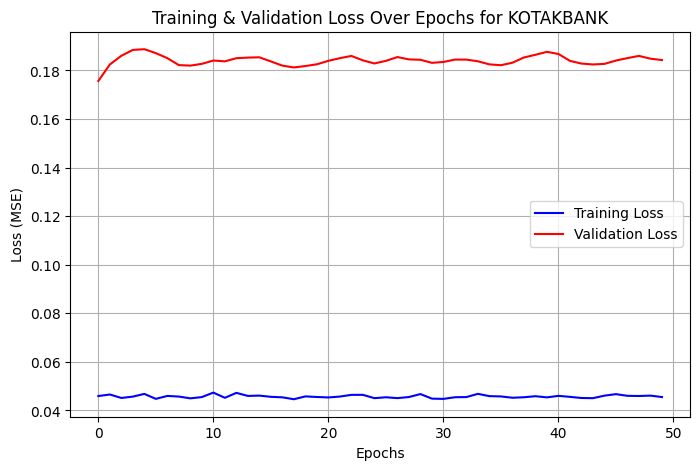

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1287, 31)
X_val shape: (160, 31)
X_test shape: (162, 31)
y_train shape: (1287,)
y_val shape: (160,)
y_test shape: (162,)
Train Samples: 1287, Validation Samples: 160, Test Samples: 162


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.118681, Val Loss: 0.049627, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.068103, Val Loss: 0.127370, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.042028, Val Loss: 0.259015, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.055961, Val Loss: 0.272357, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.049498, Val Loss: 0.190039, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.041006, Val Loss: 0.131785, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.043498, Val Loss: 0.140618, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.040811, Val Loss: 0.175962, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.040176, Val Loss: 0.192875, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.041209, Val Loss: 0.186083, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.040779, Val Loss: 0.168636, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.041489, Val Loss: 0.154979, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.040174, Val Loss: 0.155116, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.040168, Val Loss: 0.163410, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.04

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([162, 1, 1])) that is different to the input size (torch.Size([162])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


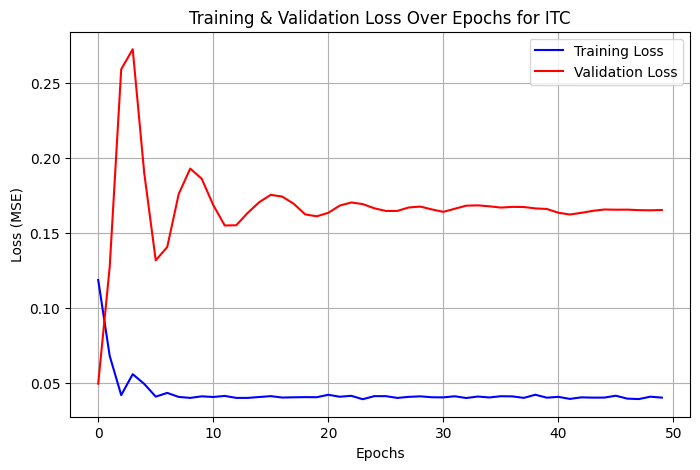

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.040498, Val Loss: 0.251994, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.036822, Val Loss: 0.197357, Time: 0.05 sec
Epoch 3/50, Train Loss: 0.035673, Val Loss: 0.165403, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.037832, Val Loss: 0.168218, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.036979, Val Loss: 0.190844, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.034856, Val Loss: 0.216481, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.035472, Val Loss: 0.226441, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.035327, Val Loss: 0.221507, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.035052, Val Loss: 0.209627, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.033954, Val Loss: 0.198739, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.035063, Val Loss: 0.192427, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.035272, Val Loss: 0.192954, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.035200, Val Loss: 0.198421, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.035109, Val Loss: 0.205977, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.03

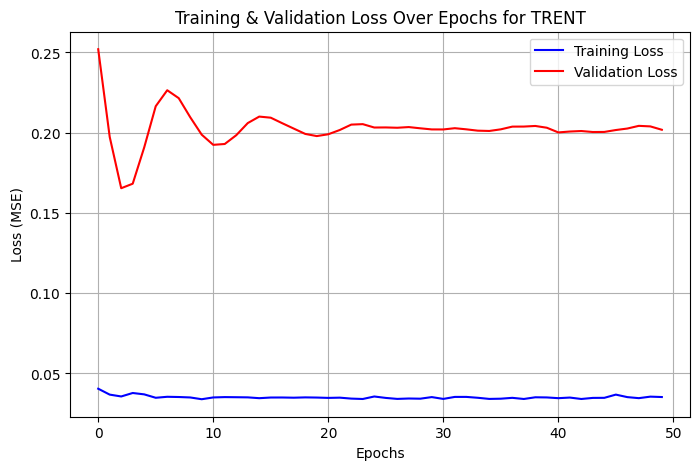

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.075788, Val Loss: 0.098733, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.068366, Val Loss: 0.059987, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.062944, Val Loss: 0.036988, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.064521, Val Loss: 0.033403, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.064282, Val Loss: 0.041675, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.063779, Val Loss: 0.055113, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.063339, Val Loss: 0.065220, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.064873, Val Loss: 0.068584, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.063305, Val Loss: 0.065526, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.064210, Val Loss: 0.057868, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.064537, Val Loss: 0.051301, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.062433, Val Loss: 0.049348, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.064104, Val Loss: 0.049777, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.061471, Val Loss: 0.053102, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.06

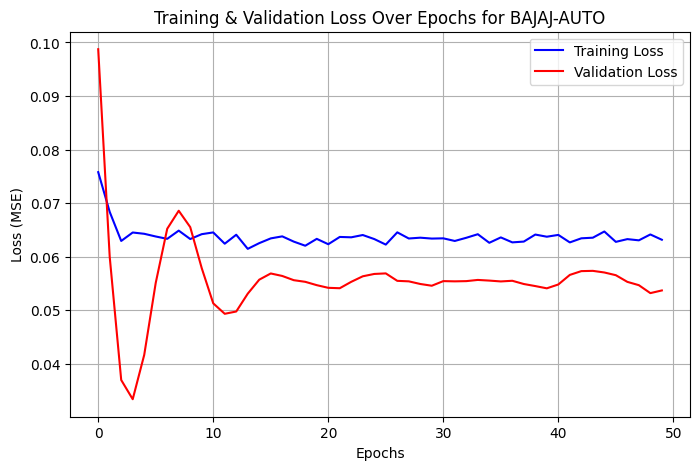

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.084115, Val Loss: 0.053670, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.054890, Val Loss: 0.098935, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.039163, Val Loss: 0.160481, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.042386, Val Loss: 0.198683, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.047393, Val Loss: 0.192495, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.043916, Val Loss: 0.155168, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.039262, Val Loss: 0.116408, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.038761, Val Loss: 0.099121, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.042071, Val Loss: 0.105603, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.039043, Val Loss: 0.124820, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.037572, Val Loss: 0.141468, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.039081, Val Loss: 0.147215, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.038277, Val Loss: 0.142374, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.038274, Val Loss: 0.132632, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.03

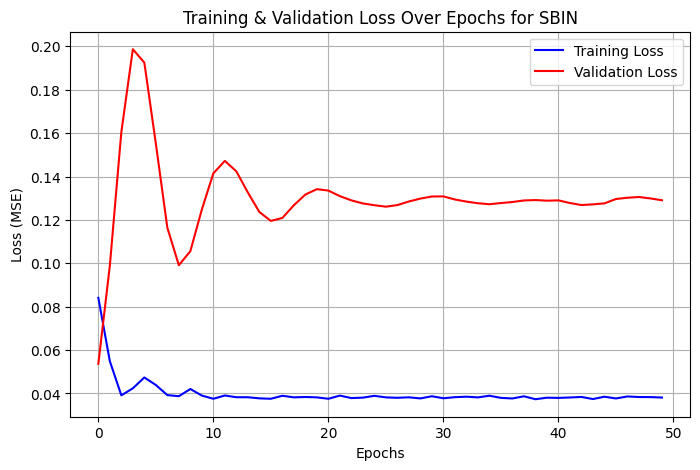

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.080295, Val Loss: 0.223941, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.068158, Val Loss: 0.157263, Time: 0.05 sec
Epoch 3/50, Train Loss: 0.062710, Val Loss: 0.110239, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.065112, Val Loss: 0.093906, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.066604, Val Loss: 0.104275, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.064472, Val Loss: 0.128634, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.062858, Val Loss: 0.152647, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.062604, Val Loss: 0.165024, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.063882, Val Loss: 0.165987, Time: 0.06 sec
Epoch 10/50, Train Loss: 0.063588, Val Loss: 0.156686, Time: 0.06 sec
Epoch 11/50, Train Loss: 0.062796, Val Loss: 0.143599, Time: 0.06 sec
Epoch 12/50, Train Loss: 0.062609, Val Loss: 0.132846, Time: 0.07 sec
Epoch 13/50, Train Loss: 0.062834, Val Loss: 0.128945, Time: 0.06 sec
Epoch 14/50, Train Loss: 0.063057, Val Loss: 0.130784, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.06

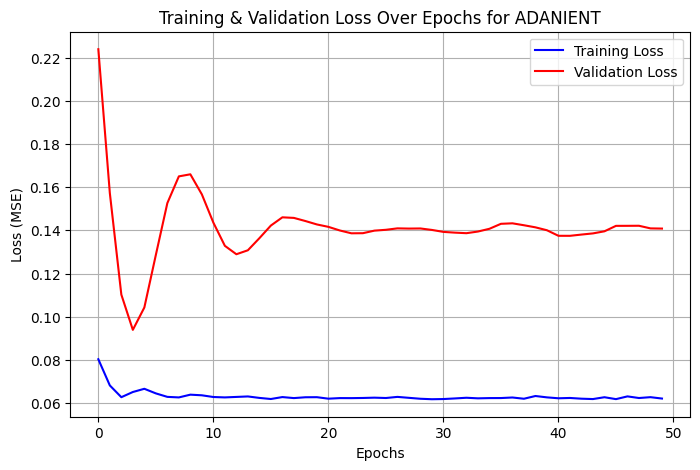

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.147391, Val Loss: 0.081881, Time: 0.23 sec
Epoch 2/50, Train Loss: 0.121258, Val Loss: 0.027742, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.104929, Val Loss: 0.002936, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.112251, Val Loss: 0.002055, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.109450, Val Loss: 0.007665, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.104678, Val Loss: 0.017334, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.105044, Val Loss: 0.023380, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.104931, Val Loss: 0.021800, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.103816, Val Loss: 0.017972, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.106787, Val Loss: 0.014072, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.104941, Val Loss: 0.013727, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.103165, Val Loss: 0.015528, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.103067, Val Loss: 0.017302, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.103442, Val Loss: 0.017738, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.10

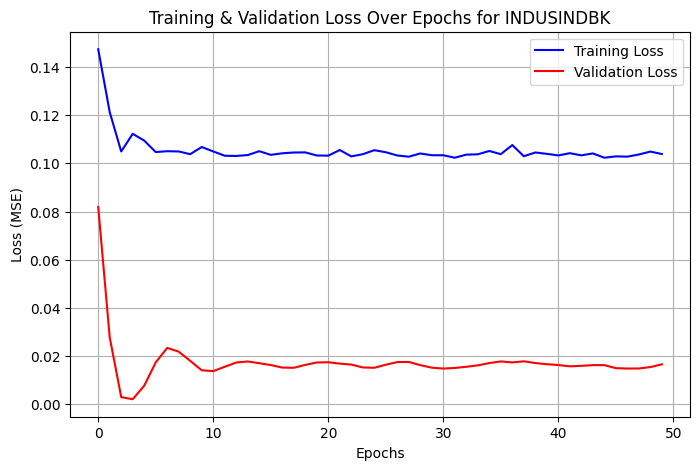

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.056059, Val Loss: 0.087505, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.047232, Val Loss: 0.049496, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.045833, Val Loss: 0.032972, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.047196, Val Loss: 0.040000, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.044179, Val Loss: 0.055804, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.044646, Val Loss: 0.067145, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.044288, Val Loss: 0.067963, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.044366, Val Loss: 0.062864, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.044688, Val Loss: 0.055497, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.044190, Val Loss: 0.049755, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.044032, Val Loss: 0.048242, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.044624, Val Loss: 0.049444, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.044442, Val Loss: 0.052022, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.043711, Val Loss: 0.055077, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.04

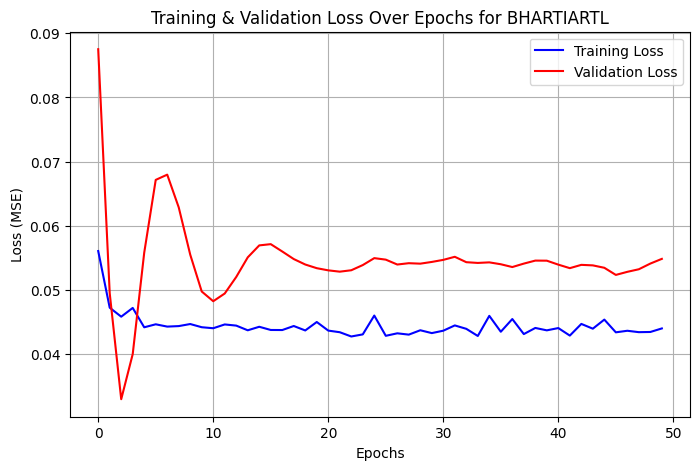

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.062913, Val Loss: 0.011254, Time: 0.26 sec
Epoch 2/50, Train Loss: 0.038451, Val Loss: 0.005301, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.028616, Val Loss: 0.027996, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.037140, Val Loss: 0.025260, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.030713, Val Loss: 0.009028, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.026593, Val Loss: 0.003987, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.029065, Val Loss: 0.003567, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.029664, Val Loss: 0.003991, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.027109, Val Loss: 0.006155, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.026684, Val Loss: 0.009130, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.026541, Val Loss: 0.010806, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.026778, Val Loss: 0.009941, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.027139, Val Loss: 0.008105, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.026724, Val Loss: 0.006690, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.02

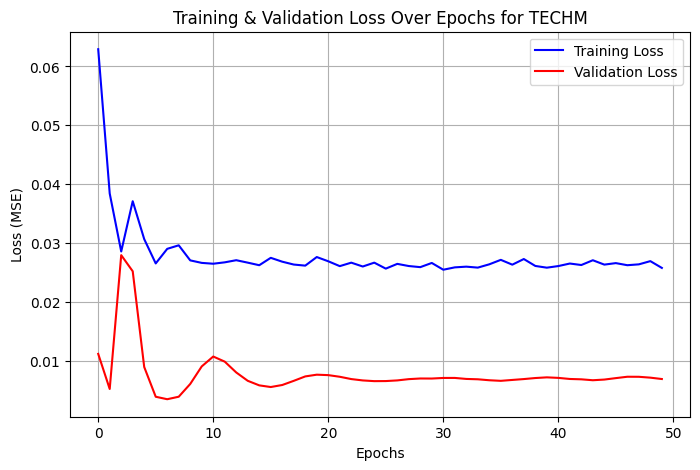

<ipython-input-31-3ead8bcf996c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
<ipython-input-31-3ead8bcf996c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["feature"] = data["close"] + data["volume"]
<ipython-input-31-3ead8bcf996c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

X_train shape: (1288, 31)
X_val shape: (161, 31)
X_test shape: (161, 31)
y_train shape: (1288,)
y_val shape: (161,)
y_test shape: (161,)
Train Samples: 1288, Validation Samples: 161, Test Samples: 161


<ipython-input-29-61bb97badd2a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-29-61bb97badd2a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarni

Epoch 1/50, Train Loss: 0.030722, Val Loss: 0.205209, Time: 0.24 sec
Epoch 2/50, Train Loss: 0.029853, Val Loss: 0.201309, Time: 0.06 sec
Epoch 3/50, Train Loss: 0.030090, Val Loss: 0.197242, Time: 0.05 sec
Epoch 4/50, Train Loss: 0.029735, Val Loss: 0.195596, Time: 0.05 sec
Epoch 5/50, Train Loss: 0.029688, Val Loss: 0.195608, Time: 0.05 sec
Epoch 6/50, Train Loss: 0.030566, Val Loss: 0.197893, Time: 0.05 sec
Epoch 7/50, Train Loss: 0.029910, Val Loss: 0.200502, Time: 0.05 sec
Epoch 8/50, Train Loss: 0.030384, Val Loss: 0.202171, Time: 0.05 sec
Epoch 9/50, Train Loss: 0.030539, Val Loss: 0.202875, Time: 0.05 sec
Epoch 10/50, Train Loss: 0.030569, Val Loss: 0.203273, Time: 0.05 sec
Epoch 11/50, Train Loss: 0.030307, Val Loss: 0.202252, Time: 0.05 sec
Epoch 12/50, Train Loss: 0.030692, Val Loss: 0.202323, Time: 0.05 sec
Epoch 13/50, Train Loss: 0.030697, Val Loss: 0.202298, Time: 0.05 sec
Epoch 14/50, Train Loss: 0.031049, Val Loss: 0.200658, Time: 0.05 sec
Epoch 15/50, Train Loss: 0.03

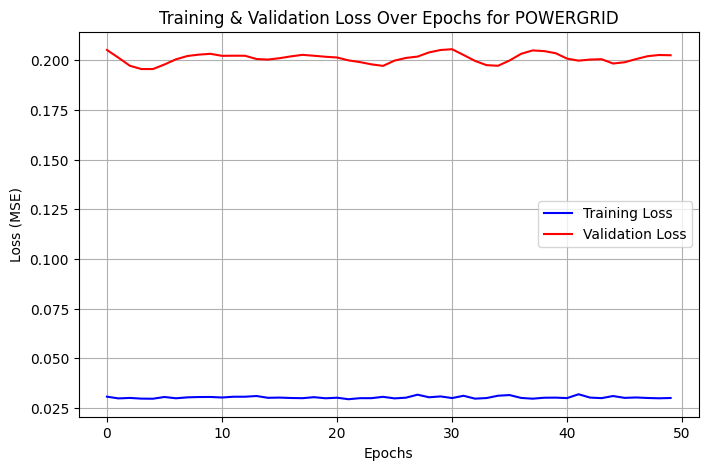

TypeError: can only concatenate str (not "float") to str

In [39]:
#for loop to get each csv file one by one and model get trained
directory_path = "/kaggle/input/new-historical-dataset/dataset/historical_data"
test_loss = 0
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        
        symbol_name = filename.replace(".csv", "")  # Extract symbol name
        file_path = os.path.join(directory_path, filename)  # Full path
        
        
        df = pd.read_csv(file_path) # Load the CSV file
        mapping_df = pd.read_csv("/kaggle/working/label_mapping.csv") # Load the label mapping CSV
        encoded_value = mapping_df.loc[mapping_df["Symbol"] == symbol_name, "Encoded_Value"].values
        df['Encoded_value'] = encoded_value[0]

        ### data preprocessing function
        train_loader,val_loader, test_loader = data_preprocessing(df,seq_length)
        
        train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)
        
        test_loss = evaluate_model(model, test_loader, criterion, device) + test_loss
        
        # Plot Training & Validation Loss
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label='Training Loss', color='blue')
        plt.plot(val_losses, label='Validation Loss', color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (MSE)')
        plt.title(f'Training & Validation Loss Over Epochs for {symbol_name}')
        plt.legend()
        plt.grid()
        plt.show()
        
print("Average test loss :",test_loss/50) 

In [44]:
print("Average test loss :",test_loss/50) 

Average test loss : 0.14941802548244595


In [ ]:
# Assuming `model` is your trained PyTorch model
model_scripted = torch.jit.script(model)  # Convert to TorchScript
torch.jit.save(model_scripted, "stock_transformer_model.pt")

Prediction Pipeline

In [ ]:
def prepare_input(new_data, stock_encoder, scaler, stock_name):
    
    new_data["timestamp"] = pd.to_datetime(new_data["timestamp"]).astype(int) // 10**9  

    stock_index = stock_encoder.get(stock_name)
    new_data["Stock"] = stock_index
    feature_columns = [ "close", "volume"]
    
    input_data = new_data[feature_columns].values

    input_data_scaled = scaler.fit_transform(input_data)
    
    input_tensor = torch.tensor(input_data_scaled, dtype=torch.float32).unsqueeze(0).to(device)  
    return input_tensor

def predict_stock_price(model, new_data_tensor):
    model.eval()
    with torch.no_grad():
        prediction = model(new_data_tensor)
    return prediction.cpu().numpy()

def inverse_transform_prediction(predicted_price, scaler, feature_index=5):  

    temp = np.zeros((predicted_price.shape[0], scaler.n_features_in_))  
    temp[:, feature_index] = predicted_price.squeeze()  # Put predictions in the correct column

    actual_price = scaler.inverse_transform(temp)[:, feature_index]  # Extract actual price values
    return actual_price

def predict_future_prices(model, new_data, stock_encoder, scaler, days=10):

    future_predictions = []
    input_seq = prepare_input(new_data, stock_encoder, scaler)

    for _ in range(days):
        pred = predict_stock_price(model, input_seq)
        future_predictions.append(pred)

        # Shift window: Remove first step, add new prediction
        pred_tensor = torch.tensor(pred, dtype=torch.float32).unsqueeze(0).to("cuda")
        input_seq = torch.cat([input_seq[:, 1:, :], pred_tensor], dim=1)

    # Convert predictions back to actual stock prices
    actual_predictions = inverse_transform_prediction(np.array(future_predictions), scaler)
    return actual_predictions


In [ ]:
new_stock = pd.read_csv('/kaggle/input/testing-dataset/tata.csv')
stock_name = "MARUTI"
new_stock = new_stock.drop(columns=["oi","open","high","low"])

In [ ]:
new_stock

In [ ]:
# Load the saved LabelEncoder
label_encoder = joblib.load("stock_label_encoder.pkl")
stock_encoder = {stock: idx for idx, stock in enumerate(label_encoder.classes_)}

# Example new data
new_stock_data = pd.DataFrame(new_stock)
scaler = MinMaxScaler(feature_range=(0, 1))
new_data_tensor = prepare_input(new_stock_data, stock_encoder, scaler, stock_name)

In [ ]:
# Single-day prediction
predicted_price = predict_stock_price(model, new_data_tensor)

In [ ]:
actual_price = inverse_transform_prediction(predicted_price, scaler)

In [ ]:
print("Predicted Stock Price:", actual_price)

# Multi-day prediction
future_prices = predict_future_prices(model, new_stock_data, stock_encoder, scaler, days=10)
print("Future Stock Predictions:", future_prices)